In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/README.md
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet


# 🧠 **Alzheimer’s MRI Disease Classification** 🏥  

## 📌 **What is Alzheimer’s Disease?**  
Alzheimer’s is a **progressive brain disorder** that causes **memory loss, confusion, and difficulty in thinking**. It is the **leading cause of dementia**, affecting millions worldwide. Over time, it worsens, making daily life challenging.  

## 🔍 **Why is Early Detection Important?**  
✅ **Slows Disease Progression:** Early diagnosis allows better symptom management.  
✅ **Better Planning:** Helps patients and families prepare for the future.  
✅ **Access to Clinical Trials:** Increases chances of trying new treatments.  
✅ **Reduces Healthcare Costs:** Early intervention lowers medical expenses.  

## 💡 **How Can AI Help?**  
Using **MRI scans and Deep Learning (CNNs)**, we can **automate Alzheimer’s detection**, making diagnosis **faster and more accurate**.  

🎯 **Goal:** Build a **CNN model** to classify MRI scans into different stages of Alzheimer’s disease. 🚀  

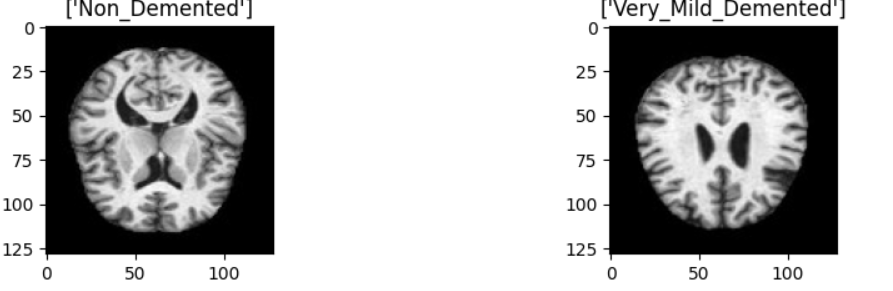
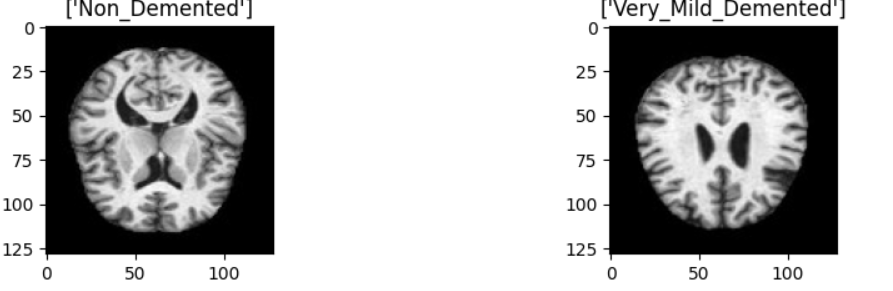

# 📂 **Dataset Overview**  

  
This dataset contains **MRI scans** for classifying different stages of Alzheimer’s disease. The images are stored in **Parquet format**, where each row represents an image in a byte-encoded format.


## 🔍 **Dataset Contents**  
✅ **MRI Images:** Brain scans converted to NumPy arrays.  
✅ **Labels:** Four categories indicating the stage of Alzheimer’s.  
✅ **Train & Test Split:** Predefined train and test datasets.  

## 🏷 **Class Labels**  
Each MRI scan is classified into **one of four categories**:  

| Label | Class Name             | Description |
|-------|------------------------|-------------|
| **0** | Mild Demented          | Early signs of dementia. |
| **1** | Moderate Demented      | Noticeable memory loss and confusion. |
| **2** | Non Demented           | Healthy brain, no signs of Alzheimer’s. |
| **3** | Very Mild Demented     | Minimal symptoms, slight cognitive decline. |

This structured dataset helps in training a **Deep Learning model (CNN)** to classify MRI scans accurately. 🧠✨  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

train = "/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet"
test = "/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet"


df_train = pd.read_parquet(train)
df_test = pd.read_parquet(test)



In [4]:
#  each image is directly stored as compressed JPEG byte data instead of file paths.
df_train.head()
#this image data is stored as dict key:value key=byte,value=

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [5]:
#print(type(image_bytes))
#<class 'dict'>

<h2>Data Preprocessing</h2>

The dataset stores MRI scan images in Parquet format, where images are saved as byte strings inside a dictionary. Since deep learning models require numerical image arrays, we need to convert these byte-encoded images into usable grayscale images.

* How It Works?
* Extracts the byte string from the dictionary.
* Converts bytes into a NumPy array (np.frombuffer).
* Decodes it into an image using cv2.imdecode(), ensuring it’s in grayscale mode.
* If the input is not a valid dictionary, it raises an error.

In [6]:
import cv2
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

We can apply this function to transform all images in the dataset

In [7]:
df_train['img_arr'] = df_train['image'].apply(dict_to_image)
df_train.drop("image", axis=1, inplace=True)
df_train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [8]:
# Create a dictionary to map labels to class names
label_mapping = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}


df_train['class_name'] = df_train['label'].map(label_mapping)


df_train.head()


,label,img_arr,class_name
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented


<h3>Explore data</h3>

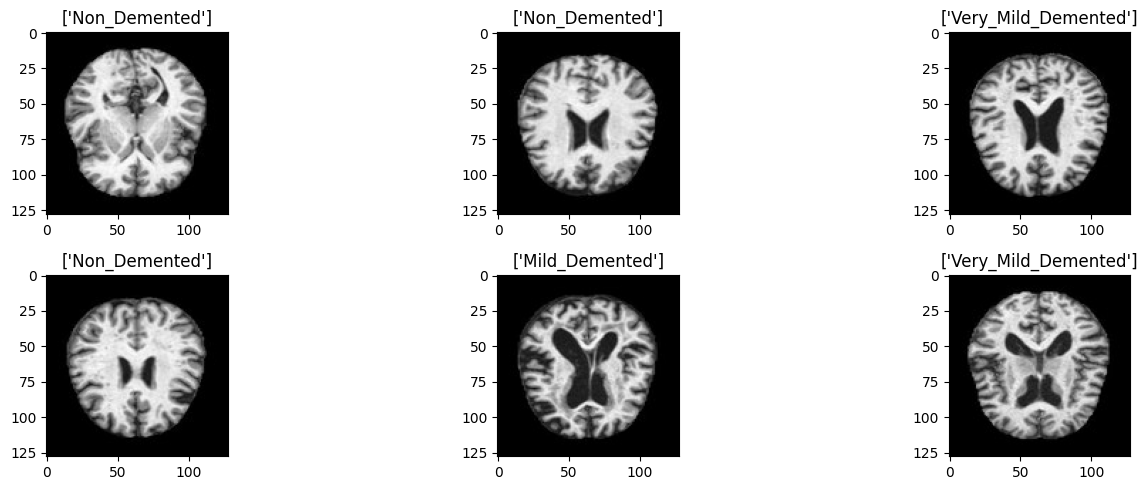

In [9]:

fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_train))
    axes.imshow(df_train.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title([df_train.iloc[rand]['class_name']])
plt.tight_layout()
plt.show()



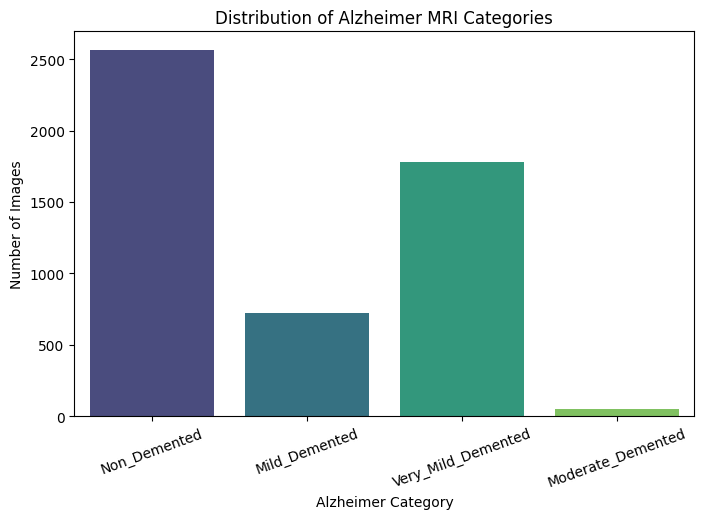

In [10]:
import seaborn as sns



plt.figure(figsize=(8, 5))

# Countplot to visualize the distribution of/ classes
sns.countplot(data=df_train, x='class_name', palette="viridis")

# Add labels and title
plt.xlabel("Alzheimer Category")
plt.ylabel("Number of Images")
plt.title("Distribution of Alzheimer MRI Categories")
plt.xticks(rotation=20)  


plt.show()


In [11]:
df_train['class_name'].value_counts()


class_name
Non_Demented          2566
Very_Mild_Demented    1781
Mild_Demented          724
Moderate_Demented       49
Name: count, dtype: int64

*dataset is imbalanced because non_demented and ver_mild_demented dominate the dataset while moderate_demented is extremly low* 


In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['class_name'], random_state=42)


In [13]:
train_df.shape,val_df.shape

((4096, 3), (1024, 3))

* Normalize images:
When working with image data, pixel values typically range from 0 to 255 
(since images are stored as 8-bit integers). Normalizing them by dividing by 255 scales these values between 0 and 1.


In [14]:

train_df['img_arr'] = train_df['img_arr'].apply(lambda x: x / 255.0)
val_df['img_arr'] = val_df['img_arr'].apply(lambda x: x / 255.0)

In [15]:
print("Training Set Class Distribution:\n", train_df['class_name'].value_counts())
print("\nValidation Set Class Distribution:\n", val_df['class_name'].value_counts())


Training Set Class Distribution:
 class_name
Non_Demented          2053
Very_Mild_Demented    1425
Mild_Demented          579
Moderate_Demented       39
Name: count, dtype: int64

Validation Set Class Distribution:
 class_name
Non_Demented          513
Very_Mild_Demented    356
Mild_Demented         145
Moderate_Demented      10
Name: count, dtype: int64


<h1>Model Building</h1>

<h1><u>Baseline model with  CNN:</h1>


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


X_train = np.stack(train_df['img_arr'].values)  # Convert to NumPy array
y_train = train_df['label'].values

X_val = np.stack(val_df['img_arr'].values)
y_val = val_df['label'].values

# Reshape X (assuming grayscale images of size 128x128)
X_train = X_train.reshape(-1, 128, 128, 1)  # (Samples, Height, Width, Channels)
X_val = X_val.reshape(-1, 128, 128, 1)

#  CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

# Train model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,  
    validation_data=(X_val, y_val),
    callbacks=[early_stop]  
)






/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4713 - loss: 1.0956 - val_accuracy: 0.5986 - val_loss: 0.8918
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6231 - loss: 0.8278 - val_accuracy: 0.6768 - val_loss: 0.7152
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7577 - loss: 0.5934 - val_accuracy: 0.8340 - val_loss: 0.4404
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8917 - loss: 0.3185 - val_accuracy: 0.8652 - val_loss: 0.3246
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9533 - loss: 0.1521 - val_accuracy: 0.9365 - val_loss: 0.2108
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9765 - loss: 0.0778 - val_accuracy: 0.9375 - val_loss: 0.1829
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9945 - loss: 0.0312 - val_accuracy: 0.9590 - val_loss: 0.1599
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9993 - loss: 0.0102 - val_accuracy: 0

In [17]:
model.save("alzheimer_detect.keras")

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,176,782 (84.60 MB)

 Trainable params: 7,392,260 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,784,522 (56.40 MB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       145
           1       1.00      1.00      1.00        10
           2       0.97      0.96      0.96       513
           3       0.94      0.97      0.95       356

    accuracy                           0.96      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.96      0.96      0.96      1024



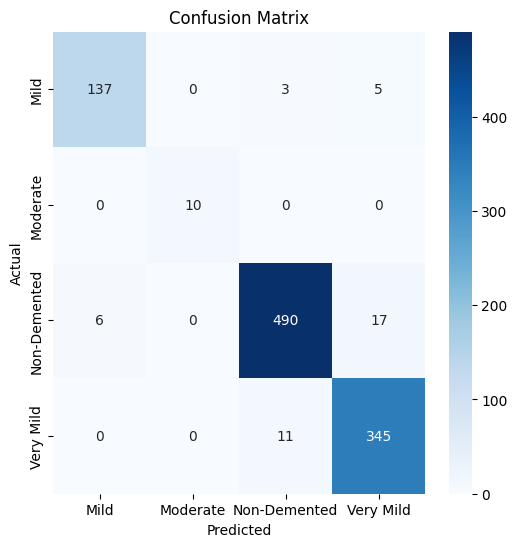

In [19]:
# Evaluate Model
y_pred = np.argmax(model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred))

#  Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mild', 'Moderate', 'Non-Demented', 'Very Mild'],
            yticklabels=['Mild', 'Moderate', 'Non-Demented', 'Very Mild'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

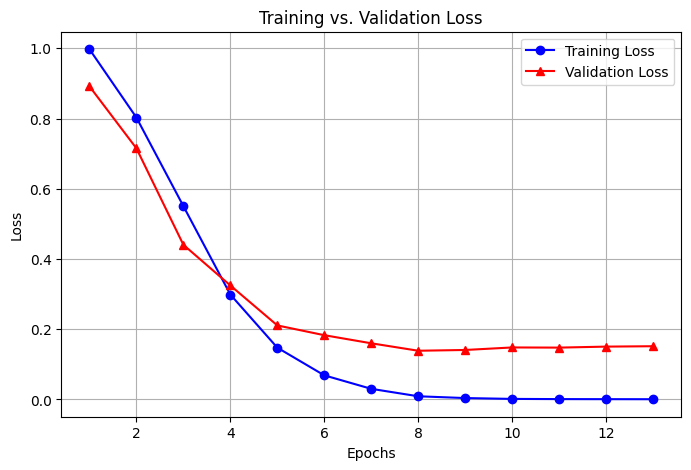

In [20]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' = blue circles with a solid line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' = red triangles with a solid line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()


<h2>Prediction on Test Data</h2>

In [21]:
df_test['img_arr'] = df_test['image'].apply(dict_to_image)
df_test.drop("image", axis=1, inplace=True)

In [22]:
df_test

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
1275,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1276,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1277,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1278,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [23]:
X_test = np.stack(df_test['img_arr'].values)  # Convert list of arrays to numpy array
y_test = df_test['label'].values  # Extract labels

X_test = X_test.reshape(-1, 128, 128, 1)  # Reshape for CNN

X_test = X_test / 255.0

y_pred_prob = model.predict(X_test)  # Get probability scores
y_pred = np.argmax(y_pred_prob, axis=1)  # Get predicted class




40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [24]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.9570
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       172
           1       1.00      0.87      0.93        15
           2       0.97      0.96      0.97       634
           3       0.93      0.97      0.95       459

    accuracy                           0.96      1280
   macro avg       0.97      0.93      0.95      1280
weighted avg       0.96      0.96      0.96      1280



In [29]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 4-class label mapping
label_mapping = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

def load_alzheimers_model(model_path="alzheimers_model.keras"):
    """
    Loads the trained Alzheimer's detection model from a .keras file.
    """
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    model = load_model(model_path)
    print("Alzheimer’s model loaded successfully from:", model_path)
    return model

def parse_parquet_image(img_dict, target_size=(128,128)):
    """
    Converts a dictionary containing a byte-encoded image into a usable grayscale image.
    
    Steps:
      1. Confirm the input is a dictionary, find the byte string (e.g. 'image_bytes').
      2. Convert bytes => np array => decode with OpenCV (grayscale).
      3. Resize to `target_size`, normalize [0..1].
      4. Expand dims => shape (1, height, width, 1).
    """
    if not isinstance(img_dict, dict):
        raise ValueError("Input must be a dictionary containing the byte-encoded image.")
    if "image_bytes" not in img_dict:
        raise KeyError("Dictionary must have key 'image_bytes' with the byte string.")
    
    # Extract the byte string from the dict
    img_bytes = img_dict["image_bytes"]
    if not isinstance(img_bytes, bytes):
        raise ValueError("The value under 'image_bytes' must be of type 'bytes'.")
    
    # Convert bytes to a 1D numpy array
    arr = np.frombuffer(img_bytes, np.uint8)
    # Decode as grayscale
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Unable to decode the byte string into an image (cv2.imdecode returned None).")
    
    # Resize
    img = cv2.resize(img, target_size)
    # Normalize [0..1]
    img = img / 255.0
    # Expand dims => shape (1, height, width, 1)
    img = np.expand_dims(img, axis=-1)  # add channel dimension
    img = np.expand_dims(img, axis=0)   # add batch dimension
    return img

def predict_alzheimers_stage(model, img_dict):
    """
    Given the model and a dictionary containing the byte-encoded image,
    preprocess and run inference. Return predicted label & confidence, plus full prob vector.
    """
    # Parse the dictionary to get a preprocessed array
    processed_image = parse_parquet_image(img_dict)
    
    # Run inference => shape: (1,4)
    preds = model.predict(processed_image)[0]  # (4,) for 4 classes
    class_idx = np.argmax(preds)
    confidence = float(preds[class_idx])
    
    # Map index to label
    predicted_label = label_mapping[class_idx]
    return predicted_label, confidence, preds

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # 1. Load the model
    model_path = "/kaggle/working/alzheimer_detect.keras"  # Change if needed
    alz_model = load_alzheimers_model(model_path)

    # 2. Example dictionary from Parquet (fake example).
    #    In reality, you'd parse your Parquet row and get the byte string from 'image_bytes'.
    with open("/kaggle/input/normal1234/c5d7c3ed6c7fe53e59c2dd902e44b9_big_gallery.jpg", "rb") as f:
        sample_bytes = f.read()
    sample_dict = {"image_bytes": sample_bytes}

    # 3. Predict
    try:
        label, confidence, prob_vec = predict_alzheimers_stage(alz_model, sample_dict)
        print(f"Prediction: {label} | Confidence: {confidence:.4f}")
        print("Full probability distribution:", prob_vec)
    except Exception as e:
        print("Error:", e)


Alzheimer’s model loaded successfully from: /kaggle/working/alzheimer_detect.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
Prediction: Non_Demented | Confidence: 1.0000
Full probability distribution: [5.7404527e-14 6.4309544e-13 9.9998653e-01 1.3465999e-05]
